In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from numba import njit
from scipy.interpolate import BarycentricInterpolator
from itertools import product
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def load_file(fp) :
    mi = np.fromfile(fp, dtype = '<u8')
    mat = np.zeros((mi.shape[0], 6), dtype = "u4") 
    mat[:,0] = mi & 31 # tdc, 0-4 (5)
    mat[:,1] = (mi & 131040) >> 5 # bx, 5-16 (12)
    mat[:,2] = (mi & 562949953290240) >> 17 # orbit, 17-48 (32)
    mat[:,3] = (mi & 287667426198290432) >> 49 # chan, 49-57 (9)
    mat[:,4] = (mi & 2017612633061982208) >> 58 # fpga (3)
    mat[:,5] = mi >> 61

    return mat

In [3]:
tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}

m = load_file('data/data_000000.dat')
df = pd.DataFrame(m, columns = ['tdc', 'bx', 'orbit', 'chan', 'fpga', 'head'])
df = df.astype(tipi)
df

,tdc,bx,orbit,chan,fpga,head
0,0,0,4079645633,100,1,1
1,2,4064,4079645602,100,1,0
2,23,1476,4079645568,100,1,4
3,16,653,4079645568,100,1,5
4,2,2922,3387200947,75,0,2
...,...,...,...,...,...,...
1310587,6,438,5797423,107,0,2
1310588,3,4092,741923455,0,0,0
1310589,18,339,741923328,0,0,4
1310590,8,1721,741923328,0,0,5


In [4]:
# rimuovo head diverso da 2
df = df[df['head'] == 2]
df

,tdc,bx,orbit,chan,fpga,head
4,2,2922,3387200947,75,0,2
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [5]:
# tengo le orbite con 2 < n < 16 hits # prima per sbaglio avevo scritto 3 < n, ma in realtà per fare un fit sensato basta 2 < n (i.e. n >= 3, non > 3)
s = df.groupby('orbit').size()
s1 = s[(s > 2) & (s < 16)].index
df = df[df.orbit.isin(s1)]
df

,tdc,bx,orbit,chan,fpga,head
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
11,28,475,3387200973,90,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [6]:
# troppa poca pazienza?
df1 = df#[:len(df)//100]
df1

,tdc,bx,orbit,chan,fpga,head
5,29,2227,3387200955,105,0,2
6,7,2234,3387200955,107,0,2
7,29,476,3387200973,126,0,2
8,12,1797,3387200955,55,1,2
11,28,475,3387200973,90,1,2
...,...,...,...,...,...,...
1310583,14,424,5797423,49,0,2
1310584,15,430,5797423,105,0,2
1310585,11,429,5797423,50,0,2
1310586,3,431,5797423,104,0,2


In [7]:
tipi

{'tdc': 'u1',
 'bx': 'u2',
 'orbit': 'u4',
 'chan': 'u2',
 'fpga': 'u1',
 'head': 'u1'}

In [8]:
def scintillatore(gruppo) :
    if ((gruppo['fpga'] == 1) & (gruppo['chan'] == 128)).any() :
        return gruppo
    else:
        return None

tipi = {'tdc':'u1', 'bx':'u2', 'orbit':'u4', 'chan':'u2', 'fpga':'u1', 'head':'u1'}
df2 = df1.groupby('orbit').apply(scintillatore).dropna().astype(tipi) # dopo apply casta tutto a float per essere compatibile con il None, credo. Per evitare un recast e risparmiare memoria si può usare una flag diversa da None/np.nan MA mi secco per un test del cavolo
df2

,tdc,bx,orbit,chan,fpga,head
6683,27,878,1118948,91,1,2
6687,8,882,1118948,107,0,2
6688,18,881,1118948,47,1,2
6689,12,884,1118948,88,1,2
6690,7,881,1118948,128,1,2
...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2
1304050,8,3552,5773565,36,1,2
1304051,6,3558,5773565,38,1,2
1304056,4,3544,5773565,120,0,2


In [9]:
# tempi
df2['t'] = 25*df2['bx'] + 25*df2['tdc']/30
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333
1304050,8,3552,5773565,36,1,2,23270.666667
1304051,6,3558,5773565,38,1,2,23419.000000
1304056,4,3544,5773565,120,0,2,23067.333333


In [10]:
# rimuovo le orbite con più scintillatori
v1, v2 = np.unique(df2.loc[df2.chan == 128, 'orbit'], return_counts = True)
df2.loc[df2.orbit.isin(v1[v2 > 1])] = None
df2 = df2.dropna().astype(tipi)
df2

,tdc,bx,orbit,chan,fpga,head,t
6683,27,878,1118948,91,1,2,21955.433333
6687,8,882,1118948,107,0,2,22056.666667
6688,18,881,1118948,47,1,2,22031.466667
6689,12,884,1118948,88,1,2,22101.466667
6690,7,881,1118948,128,1,2,22030.833333
...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333
1304050,8,3552,5773565,36,1,2,23270.666667
1304051,6,3558,5773565,38,1,2,23419.000000
1304056,4,3544,5773565,120,0,2,23067.333333


In [11]:
# def time_pedestal(gruppo) :
#     gruppo.loc['t0'] = gruppo.loc[gruppo['chan'] == 128, 't0'].values # questa cosa funziona solo se c'è un unico scintillatore per orbita, cfr cella sopra
#     return gruppo

#df2['t0'] = None
#df2 = df2.groupby('orbit').apply(time_pedestal) # non gli piace
s = df2.loc[df2['chan'] == 128, ['orbit', 't']].set_index('orbit')
df2['t0'] = s.loc[df2.orbit].t.to_numpy()
#s.loc[s.index == df2.orbit.unique()] # non mi serve

df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000


In [12]:
df2.iloc[:20] # tutto ok

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6690,7,881,1118948,128,1,2,22030.833333,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
6692,17,883,1118948,90,1,2,22080.633333,22030.833333
6693,1,891,1118948,138,1,2,22275.833333,22030.833333
6694,5,887,1118948,46,1,2,22179.166667,22030.833333
6695,12,889,1118948,89,1,2,22226.466667,22030.833333


In [13]:
# rimuovo gli scintillatori, che non possono essere piazzati in nessuna colonna in particolare
# NON SOLO QUELLI! Ci sono canali spuri ancora al di sopra
#df2.loc[df2['chan'] == 128] = None  # non basta
df2.loc[df2['chan'] > 127] = None 
df2.dropna(inplace = True)

# alternativa dask-safe e probabilmente più efficiente: df2 = df2[df2['chan] < 128]

df2 = df2.astype(tipi)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0
6683,27,878,1118948,91,1,2,21955.433333,22030.833333
6687,8,882,1118948,107,0,2,22056.666667,22030.833333
6688,18,881,1118948,47,1,2,22031.466667,22030.833333
6689,12,884,1118948,88,1,2,22101.466667,22030.833333
6691,14,881,1118948,44,1,2,22028.133333,22030.833333
...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000


In [14]:
# assegno la camera
df2['chamber'] = 23 # un numero a caso che però non è None (che non "entra" in un intero)

df2.loc[(df2['fpga'] == 0) & (df2['chan'] < 64), 'chamber'] = 0
df2.loc[(df2['fpga'] == 0) & (df2['chan'] > 63), 'chamber'] = 1
df2.loc[(df2['fpga'] == 1) & (df2['chan'] < 64), 'chamber'] = 2
df2.loc[(df2['fpga'] == 1) & (df2['chan'] > 63), 'chamber'] = 3

# assegno il layer
# layer: facciamo che contiamo da 0 a 3 partendo dal basso
df2['layer'] = df2['chan'] % 4
df2['layer'].replace({0:3, 3:0}, inplace = True) # 2:2, 1:1

# resetto/aggiorno i tipi
tipi2 = tipi
tipi2['chamber'] = 'u1'
tipi2['layer'] = 'u1'
df2 = df2.astype(tipi2)

df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
6683,27,878,1118948,91,1,2,21955.433333,22030.833333,3,0
6687,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
6688,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
6689,12,884,1118948,88,1,2,22101.466667,22030.833333,3,3
6691,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
1304049,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1
1304050,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3
1304051,6,3558,5773565,38,1,2,23419.000000,22991.300000,2,2
1304056,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3


In [15]:
#pd.DataFrame(df2.groupby(['orbit', 'chamber']).nunique()['layer'])

In [16]:
# tolgo eventi (groupby orbit and chamber) con meno di 3 eventi (un fit con 2 punti non ha senso, e ho già tolto gli scintillatori)
#df2 = df2[df2.groupby(['orbit', 'chamber']).nunique()['layer'] > 2] #questa riga può funzionare solo se df2 ha come index [orbit, chamber] se no c'è un mismatch nel tipo di indici!!

def numero_di_layers(gruppo):
    if gruppo.nunique()['layer'] > 2 :
        return gruppo
    else :
        return None

df2backup = df2.copy()
#df2 = df2backup.copy()

df2 = df2.groupby(['orbit', 'chamber']).apply(numero_di_layers).dropna().reset_index(drop = True).astype(tipi2) # senza drop = True in reset index dà errore
df2 # passano quasi tutti

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
1,20,890,1118948,105,0,2,22258.133333,22030.833333,1,1
2,13,891,1118948,108,0,2,22277.300000,22030.833333,1,3
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
4358,30,3537,5773565,39,1,2,22896.933333,22991.300000,2,0
4359,25,3538,5773565,38,1,2,22917.766667,22991.300000,2,2
4360,1,3551,5773565,41,1,2,23239.833333,22991.300000,2,1
4361,8,3552,5773565,36,1,2,23270.666667,22991.300000,2,3


In [17]:
a1, a2 = np.unique(df2backup.iloc[:11]['chamber'], return_counts = True)
print(a1, a2) # non è un esempio buono lol ma mi secco a cercarne uno

[1 2 3] [3 4 4]


In [18]:
b1, b2 = np.unique(df2.iloc[:11]['chamber'], return_counts = True)
print(b1, b2) # inutile

[1 2 3] [3 4 4]


In [19]:
# # perché il fit funzioni devo togliere gli eventi con troppe hits sullo stesso layer
# # def stesso_layer(gruppo) :
# #     if len(gruppo['layer'].unique()) == 

# # stessa idea ma senza apply
# df2 = df2.set_index(['orbit', 'chamber'])
# #df2 = df2[df2.groupby(['orbit', 'chamber']).size() == df.groupby(['orbit', 'chamber']).nunique()["layer"]] # oppure vai di set_index() e qui usi groupby(df2.index), come fatto per Zanetti
# # stesso commento di prima: questa riga può funzionare solo se df2 ha come index [orbit, chamber] se no c'è un mismatch nel tipo di indici!!

# df2 = df2[df2.groupby(df2.index).size() == df.groupby(df2.index).nunique()["layer"]].reset_index(drop = True).astype(tipi2)
# # credo sia più efficiente fare un set index una tantum e poi groupby per index, che dovrebbe essere più efficiente rispetto alle altre colonne
# # tuttavia non ne sono sicuro, comunque bisognerebbe fare la prova. cfr https://docs.dask.org/en/latest/dataframe.html

# # è anche vero che qui non sto facendo groupby + apply... boh
# df2

In [20]:
# non funziona niente qua sopra, facciamo alla vecchia maniera
def stesso_layer(gruppo) :
    if gruppo['layer'].nunique() == len(gruppo) :
        return gruppo
    else :
        return None 
    
df2 = df2.groupby(['orbit', 'chamber']).apply(stesso_layer).dropna().reset_index(drop = True).astype(tipi2)
df2

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer
0,8,882,1118948,107,0,2,22056.666667,22030.833333,1,0
1,20,890,1118948,105,0,2,22258.133333,22030.833333,1,1
2,13,891,1118948,108,0,2,22277.300000,22030.833333,1,3
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,0
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,3
...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,3
3209,28,3539,5773565,119,0,2,22945.266667,22991.300000,1,0
3210,11,3545,5773565,118,0,2,23089.633333,22991.300000,1,2
3211,4,3544,5773565,120,0,2,23067.333333,22991.300000,1,3


In [21]:
# ok no, recupero la convenzione che contiamo da 1 per pigrizia (sia tdc che layer)
# COME NON DETTO; GEOMETRIA TROPPO DIFFERENTE, DEVO RIVEDERE I CONTI IN OGNI CASO!

# In ogni caso PURE PER LORO LAYER VA DA 1 IN BASSO A 4 IN ALTO!!
df3 = df2.copy()

df3['layer'] += 1
# df3['chan'] += 1
# df3.loc[df3["chan"] > 64,"chan"] -= 64 

# f = BarycentricInterpolator([1,2,3,4],[0,2,1,3])

# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)

df3.loc[df3["chan"] > 63,"chan"] -= 64

f = BarycentricInterpolator([1,2,3,4],[1,3,2,4])
df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8)
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12
...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15


In [22]:
df3.column.max() # ora va bene (se tolgo tutti i canali sopra il 127)

16

In [23]:
# df3["column"] = ((df3['chan'] + f(df3["layer"])) / 4).astype(np.uint8) # questa lettura fallisce se lasci gli scintillatori, che hanno chan 64 e quindi ricevono col == 17
# print(df3['column'].max())

In [24]:
# roba vecchia:
# #np.arange(1,33,2): centers in the first layers have coordinates: dx*1/2, dx+dx*1/2=dx*3/2, dx+dx*3/2=dx*5/2,... Therefore in dx/2 units our coordinates are: 1,3,5,... i.e. odd numbers up to (16-1/2)*dx=31*(dx/2);we can hence use np.arange() with 33 as second argument since stop is not included.
# #np.arange(2,34,2): the second layer behaves exactly like the first but with a dx/2 horizontal shift i.e. 1 in dx/2 units. We can also use np.arange(1,33,2)+1, which easier to understand but not really necessary

# centers_coords = np.vstack((np.arange(1,33,2),np.arange(2,34,2))) #2 rows corresponding to the first 2 layers
# centers_coords = np.vstack((centers_coords,centers_coords)) #layer 3 and 4 are a copy of 1 & 2

# df["CENTER"] = centers_coords[df.LAYER-1,df.COLUMN-1] #-1 is needed to fix different conventions (i.e. whether we count from 0 or 1)
# df #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1


centers_coords = np.vstack((np.arange(2,34,2),np.arange(1,33,2))) # ok. invertito è giusto come deve essere, ho fatto un check con le prime righe/colonne
centers_coords = np.vstack((centers_coords,centers_coords))
print(centers_coords)

df3["center"] = centers_coords[df3.layer-1,df3.column-1] 
df3 #To check whether the result is correct notice that if layer is even then center = column*2, otherwise center = column*2-1

[[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]
 [ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32]
 [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]]


,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23
...,...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11,21
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14,28
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14,28
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29


In [25]:
time_offset = np.array([-1.1, 6.4, 0.5, -2.6])

# l'offset è PER CHAMBER, sia per dt che per z!!!

df3['dt'] = df3['t'] - df3['t0'] + 95 + time_offset[df3['chamber']] # chamber va da 0
df3

,tdc,bx,orbit,chan,fpga,head,t,t0,chamber,layer,column,center,dt
0,8,882,1118948,43,0,2,22056.666667,22030.833333,1,1,11,22,127.233333
1,20,890,1118948,41,0,2,22258.133333,22030.833333,1,2,11,21,328.700000
2,13,891,1118948,44,0,2,22277.300000,22030.833333,1,4,12,23,347.866667
3,18,881,1118948,47,1,2,22031.466667,22030.833333,2,1,12,24,96.133333
4,14,881,1118948,44,1,2,22028.133333,22030.833333,2,4,12,23,92.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3208,17,1041,5762142,40,1,2,26030.633333,25777.100000,2,4,11,21,349.033333
3209,28,3539,5773565,55,0,2,22945.266667,22991.300000,1,1,14,28,55.366667
3210,11,3545,5773565,54,0,2,23089.633333,22991.300000,1,3,14,28,199.733333
3211,4,3544,5773565,56,0,2,23067.333333,22991.300000,1,4,15,29,177.433333


In [26]:
print(np.count_nonzero(df3.dt > 0)/len(df3)*100)

99.2530345471522


In [27]:
# faccio un po' di pulizia un momento
df4 = df3.copy()[['orbit', 'chamber', 'layer', 'center', 'dt']]
df4

,orbit,chamber,layer,center,dt
0,1118948,1,1,22,127.233333
1,1118948,1,2,21,328.700000
2,1118948,1,4,23,347.866667
3,1118948,2,1,24,96.133333
4,1118948,2,4,23,92.800000
...,...,...,...,...,...
3208,5762142,2,4,21,349.033333
3209,5773565,1,1,28,55.366667
3210,5773565,1,3,28,199.733333
3211,5773565,1,4,29,177.433333


In [28]:
# 42/2 = 21
vd = 53.8*1e-3 # v_drift = 53.8 um/ns, voglio lavorare con i millimetri
df4['xr'] = df4['center']*21 + vd*df4['dt']
df4['xl'] = df4['center']*21 - vd*df4['dt']
df4

,orbit,chamber,layer,center,dt,xr,xl
0,1118948,1,1,22,127.233333,468.845153,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940
2,1118948,1,4,23,347.866667,501.715227,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360
...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007
3209,5773565,1,1,28,55.366667,590.978727,585.021273
3210,5773565,1,3,28,199.733333,598.745653,577.254347
3211,5773565,1,4,29,177.433333,618.545913,599.454087


In [29]:
z_offset = np.array([219.8, 977.3, 1035.6, 1819.8])
dz2 = 13/2

# l'offset è PER CHAMBER, sia per dt che per z!!!

df4['z'] = df4['layer']*dz2 + z_offset[df4['chamber']]
df4

,orbit,chamber,layer,center,dt,xr,xl,z
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6
...,...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007,1061.6
3209,5773565,1,1,28,55.366667,590.978727,585.021273,983.8
3210,5773565,1,3,28,199.733333,598.745653,577.254347,996.8
3211,5773565,1,4,29,177.433333,618.545913,599.454087,1003.3


In [30]:
c = df4[(df4.orbit == df4.orbit.iloc[0]) & (df4.chamber == 3)]
c

,orbit,chamber,layer,center,dt,xr,xl,z
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8


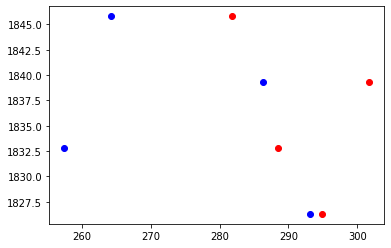

In [31]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue");

In [32]:
# @njit 
# def numba_score(combin,eventZ) :
#     s = np.zeros(combin.shape[0]) 
#     for i, c in enumerate(combin) :
#         if ((eventZ - eventZ.mean())**2).sum() == 0 : # dice che se no ci sono delle divisioni per zero anche se non riesco a riprodurle a mano... assurdo
#             s[i] = 0 #np.nan
#         else :
#             slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
#             intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

#             s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
#     return s

# ok, credo che servisse quel protector per compensare la mancanza del filtro che rimuove eventi con più celle attive nello stesso layer
@njit 
def numba_score(combin,eventZ) :
    s = np.zeros(combin.shape[0]) 
    for i, c in enumerate(combin) :
        slope = ((eventZ - eventZ.mean())*(c - c.mean())).sum() / ((eventZ - eventZ.mean())**2).sum()
        intercept = c.mean() - slope*eventZ.mean() # cfr https://en.wikipedia.org/wiki/Simple_linear_regression con x e y scambiati

        s[i] = np.linalg.norm(c - (slope*eventZ+intercept))
    return s




def solve_ambiguity(event):
    combin = np.array(list(product(*event.loc[:, ['xr','xl']].to_numpy())))
    s = numba_score(combin,event.z.to_numpy())
    event['xb'] = combin[s.argmin()]
    return event

In [33]:
# df2 = df2.reset_index().groupby(["ORBIT_CNT","EVENT"], group_keys=False).apply(solve_ambiguity2) #reset_index() is needed to make this work
# df2 = df2.set_index(["ORBIT_CNT","EVENT"])
# df2
c = c.groupby(['orbit', 'chamber']).apply(solve_ambiguity) # tutto va fatto localmente per ora (sia nello spazio che nel tempo!)
c

,orbit,chamber,layer,center,dt,xr,xl,z,xb
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193


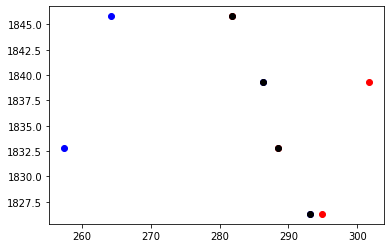

In [34]:
plt.scatter(c.xr, c.z, c = "red")
plt.scatter(c.xl, c.z, c = "blue")
plt.scatter(c.xb, c.z, c = "black");

In [35]:
df5 = df4.copy()
df5 = df5.groupby(['orbit', 'chamber']).apply(solve_ambiguity)
df5

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
...,...,...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007,1061.6,459.777993
3209,5773565,1,1,28,55.366667,590.978727,585.021273,983.8,590.978727
3210,5773565,1,3,28,199.733333,598.745653,577.254347,996.8,598.745653
3211,5773565,1,4,29,177.433333,618.545913,599.454087,1003.3,599.454087


In [36]:
# for index, subframe in tqdm(df4.groupby(['orbit', 'chamber'])) :
#    display(solve_ambiguity(subframe))

In [37]:
# ve = df4.loc[df4.orbit == df4.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1,4))
# ve

In [38]:
# for i in range(3) :
#     print(((ve[i] - ve[i].mean())**2).sum())

In [39]:
# df5.loc[df5.orbit == df5.orbit.unique()[35]]

In [40]:
# tutti questi sort non mi servono, ma non fa niente perché questa cella era solo un test (infatti ha un hardcoding che fa schifo! Orbita 35: 4 eventi per camera, 3 camere)
# quanto scritto qua sopra valeva solo quando per sbaglio all'inizio c'era < 15 anziché < 16

# vxr = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xr.to_numpy().reshape((-1, 4))
# vxl = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xl.to_numpy().reshape((-1, 4))
# vxb = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').xb.to_numpy().reshape((-1, 4))
# vz = df5.loc[df5.orbit == df5.orbit.unique()[35]].sort_values('chamber').z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

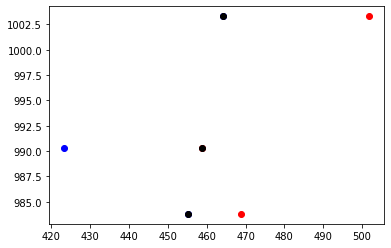

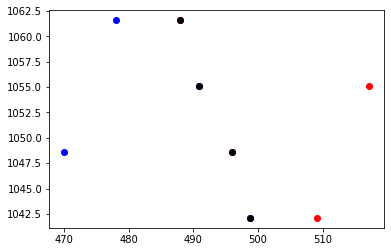

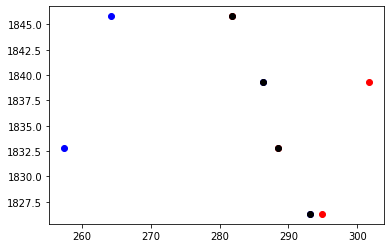

In [41]:
n = 0 # numero orbita da visualizzare
tmp = df5.loc[df5.orbit == df5.orbit.unique()[n]]#.sort_values('chamber') # a che mi serve questo sort? Tanto ad ogni x accoppio la sua z... boh

# voglio una riga per camera, ciascuna contenente tutte le hits di quella camera

# vxr = tmp.xr.to_numpy().reshape((-1, 4))
# vxl = tmp.xl.to_numpy().reshape((-1, 4))
# vxb = tmp.xb.to_numpy().reshape((-1, 4))
# vz = tmp.z.to_numpy().reshape((-1, 4))
# for i in range(3) :
#     fig, ax = plt.subplots()
#     ax.scatter(vxl[i], vz[i], c = 'blue')
#     ax.scatter(vxr[i], vz[i], c = 'red')
#     ax.scatter(vxb[i], vz[i], c = 'black')

for ch in tmp.chamber.unique() :
    vxr = tmp[tmp.chamber == ch].xr
    vxl = tmp[tmp.chamber == ch].xl
    vxb = tmp[tmp.chamber == ch].xb
    vz = tmp[tmp.chamber == ch].z

    fig, ax = plt.subplots()
    ax.scatter(vxl, vz, c = 'blue')
    ax.scatter(vxr, vz, c = 'red')
    ax.scatter(vxb, vz, c = 'black')


In [42]:
# si può fare una funzione "fit" che calcoli pendenza e intercetta (njit); questa stessa può essere usata sia per il calcolo del chi quadro che riciclata per il fit globale

***
### Il filtro della vicinanza orizzontale che fine ha fatto? Viene soppiantato dal filtro di non più di una cella attiva per layer? Verificare
***
Risposta: no. Al massimo può venire rimpiazzato da quello dei < 8 eventi per orbita, ora controllo

In [43]:
df2d = df5.copy() # pronti per il fit globale 2D; tolgo la camera 1 che è rilevante solo per quello 3d
df2d = df2d[df2d['chamber'] != 1]
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3204,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673
3205,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827
3206,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
3207,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767


Importantissimo ri-assicurarsi che ogni coppia orbita/camera contenga almeno 3 punti per il fit (cosa non più scontata avendo rimosso la camera 1)!! Se no possono esserci orbite con un solo punto che soddisfano z == z.mean() banalmente!!

In [44]:
S = df2d.groupby('orbit').size()
Si = S[S > 2].index
df2d = df2d[df2d.orbit.isin(Si)] # l'indice di S è orbit!!
df2d # con solo il primo file per fortuna non cambia nulla (che è il motivo per cui non me ne sono accorto)

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3204,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673
3205,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827
3206,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
3207,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767


In [45]:
# test
df2d.groupby(['orbit']).nunique()

,chamber,layer,center,dt,xr,xl,z,xb
orbit,,,,,,,,
1118948,2,4,4,8,8,8,8,8
1123056,2,4,5,8,8,8,8,8
1124284,2,4,4,8,8,8,8,8
1126947,2,4,4,8,8,8,8,8
1130581,2,4,4,7,7,7,7,7
...,...,...,...,...,...,...,...,...
5723739,1,3,2,3,3,3,3,3
5738703,1,3,2,3,3,3,3,3
5741793,2,4,5,8,8,8,8,8


In [46]:
# test
df2d['orbit'].unique().shape[0] # numero di orbite uniche

363

In [47]:
# test
df2d.groupby(['orbit']).nunique()['chamber'] > 1 # quali di queste 295 orbite hanno almeno 2 valori distinti di chamber?

orbit
1118948     True
1123056     True
1124284     True
1126947     True
1130581     True
           ...  
5723739    False
5738703    False
5741793     True
5744493    False
5762142     True
Name: chamber, Length: 363, dtype: bool

In [48]:
# test
print(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1].shape[0])
df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1]

184


array([1118948, 1123056, 1124284, 1126947, 1130581, 1135298, 1144838,
       1151335, 1175583, 1190501, 1248672, 1273848, 1324275, 1340132,
       1359360, 1378974, 1457838, 1494528, 1510870, 1526415, 1563057,
       1580971, 1589457, 1616334, 1627535, 1647343, 1652809, 1678645,
       1689723, 1691363, 1696794, 1701734, 1776978, 1777546, 1785150,
       1800192, 1807938, 1843749, 1865842, 1875545, 1875743, 1875773,
       1906563, 1915299, 1974647, 1980146, 2000410, 2040732, 2175677,
       2194162, 2229354, 2243090, 2310920, 2336876, 2345052, 2355233,
       2399681, 2422956, 2468012, 2493277, 2503604, 2556847, 2565416,
       2578826, 2673209, 2684383, 2698072, 2730461, 2734116, 2751422,
       2752751, 2781075, 2898095, 2933770, 2939904, 2972885, 2976721,
       3005472, 3049467, 3065545, 3094166, 3129186, 3144497, 3175239,
       3197532, 3213892, 3222537, 3308419, 3315584, 3329716, 3340311,
       3350971, 3366545, 3371031, 3451489, 3479327, 3510223, 3526395,
       3538387, 3574

In [49]:
# da df2d devo togliere le orbite che non abbiano almeno 2 camere (senza contare 1 che ho tolto, ovviamente)
df2d = df2d[df2d.orbit.isin(df2d['orbit'].unique()[df2d.groupby(['orbit']).nunique()['chamber'] > 1])]
df2d

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
3204,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673
3205,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827
3206,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
3207,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767


In [50]:
# ALTERNATIVA SENZA ISIN (più dask-friendly): qualcosa tipo la seguente

def filtro2d(gruppo) :
    if len(gruppo['chamber'].unique()) > 1 :
        return gruppo
    else : 
        return None

df2d_altro = df2d.groupby("orbit").apply(filtro2d).reset_index(drop = True).dropna()
df2d_altro

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
...,...,...,...,...,...,...,...,...,...
1426,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673
1427,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827
1428,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600
1429,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767


A giudicare dalla len df2d e df2d_altro sono uguali, buono

In [51]:
@njit
def fit(z, x) : # ricorda: nel nostro fit (rispetto a wikipedia) si ha x -> z (variabile fissa/senza errore/senza osservazioni da confrontare con predizioni) e y -> x (tutto il contrario dell'altra)
    slope = ((z - z.mean())*(x - x.mean())).sum() / ((z - z.mean())**2).sum()
    intercept = x.mean() - slope * z.mean()
    return slope, intercept # geometricamente queste due sono "sbagliate" ma filosoficamente e numericamente no!
    # questi due parametri soddisfano l'equazione x = slope*z+intercept visto quanto detto sopra su x, y e z

In [52]:
df2d[df2d.orbit == df2d.orbit.unique()[0]] # nota che i valori di z sono già globali!!

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193


In [53]:
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}') # nello stesso evento per definizione tutte le orbite sono uguali, basta la prima con iloc anziché unique ecc.
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

In [54]:
print('unique number of orbits:', df2d.orbit.unique().shape[0])

unique number of orbits: 184


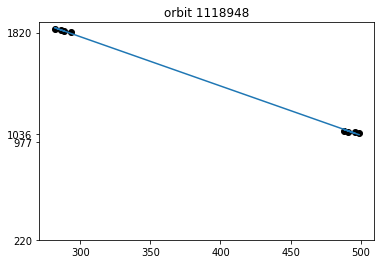

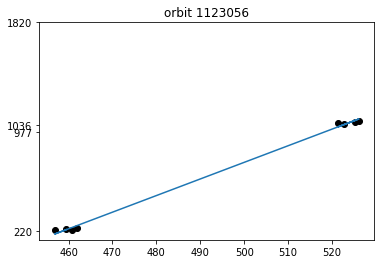

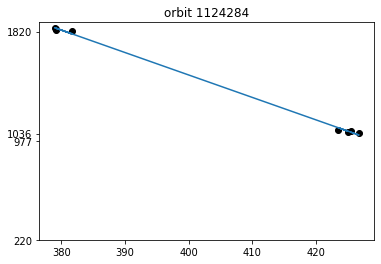

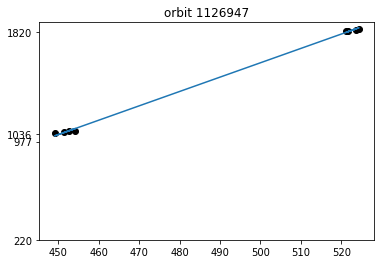

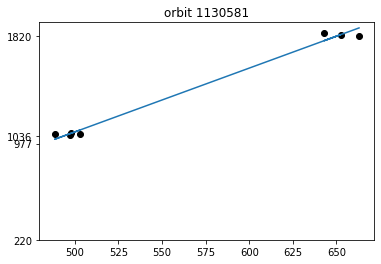

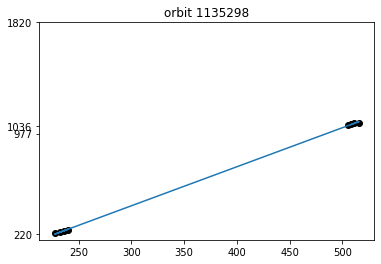

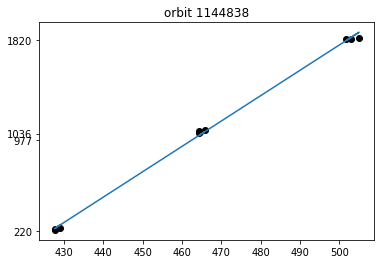

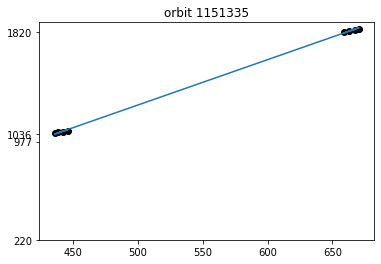

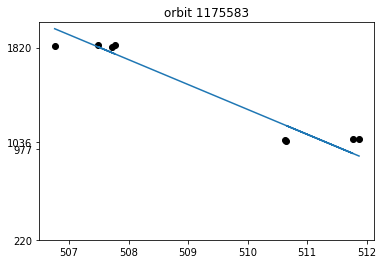

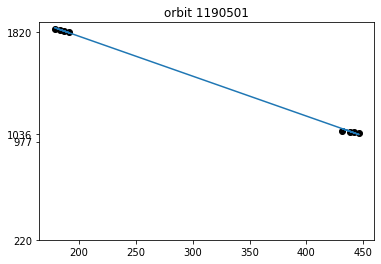

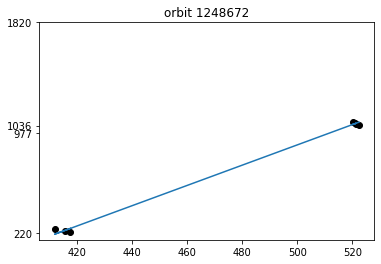

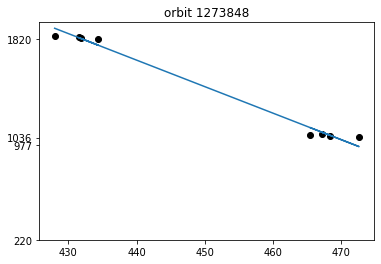

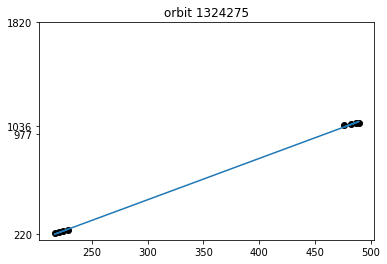

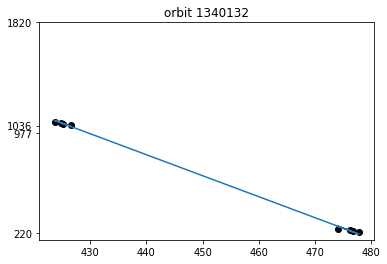

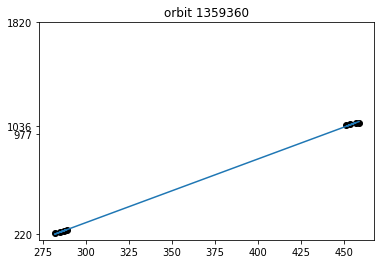

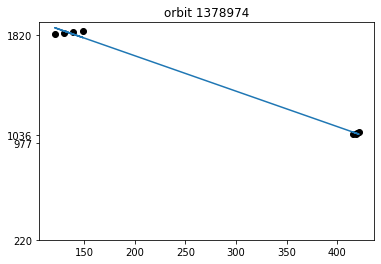

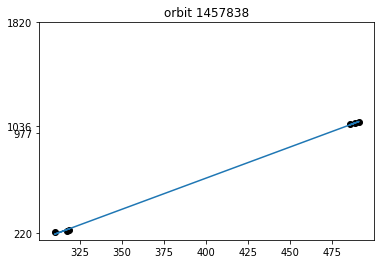

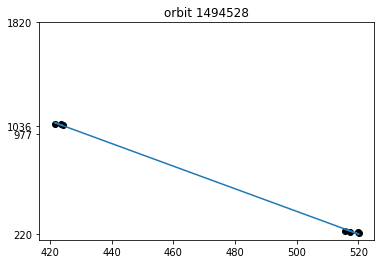

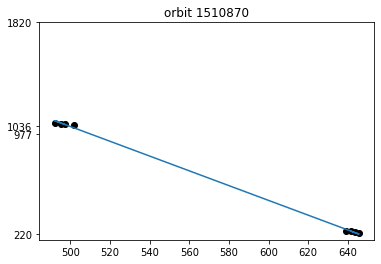

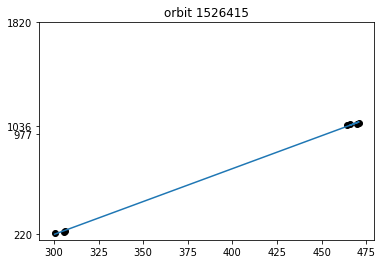

In [55]:
for i in range(20) :
    plot_global_fit(df2d[df2d.orbit == df2d.orbit.unique()[i]])

In [56]:
df2d[df2d.orbit == 1175583]

,orbit,chamber,layer,center,dt,xr,xl,z,xb
114,1175583,2,3,24,146.333333,511.872733,496.127267,1055.1,511.872733
115,1175583,2,1,24,123.633333,510.651473,497.348527,1042.1,510.651473
116,1175583,2,4,25,245.933333,538.231213,511.768787,1061.6,511.768787
117,1175583,2,2,25,267.166667,539.373567,510.626433,1048.6,510.626433
118,1175583,3,3,24,64.900000,507.491620,500.508380,1839.3,507.491620
119,1175583,3,1,24,69.066667,507.715787,500.284213,1826.3,507.715787
120,1175583,3,4,25,320.333333,542.233933,507.766067,1845.8,507.766067
121,1175583,3,2,25,339.066667,543.241787,506.758213,1832.8,506.758213


## Serve la vicinanza orizzontale
Intanto però vediamo se i residui possano essere usati in tal senso

In [57]:
def residui(gruppo) :
    # nota importante: come detto dal tipo della tesi è interessante calcolare i residui definiti rispetto al fit *globale*
    slope, intercept = fit(gruppo['z'].to_numpy(), gruppo['xb'].to_numpy()) # infatti qui fitto sui dati già senza ambiguità...
    gruppo['residui'] = gruppo['xb'] - slope*gruppo['z']-intercept # x osservato - x predetto
    return gruppo 

df2d_2 = df2d.groupby('orbit').apply(residui).reset_index(drop = True) # ...e qui NON raggruppo per chamber
df2d_2

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
1426,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673,2.164219
1427,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827,-1.656821
1428,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-0.317189
1429,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767,-0.210408


5.015023221035178e-13


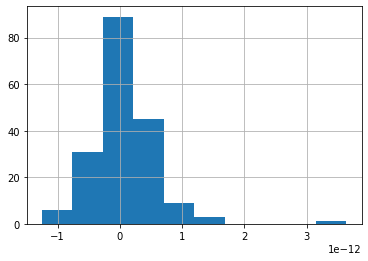

In [58]:
s = df2d_2.groupby('orbit').apply(lambda gruppo: gruppo.residui.sum())
print(s.std())
s.hist();
# assolutamente inutile (sono tutti 0 stando ai float ecc.), il che conferma che effettivamente quella di somma dei residui = 0 è una identità soddisfatta sempre per via di come calcolo alpha e beta, non eliminata da rumore o eventuali errori casuali/sistematici

In [59]:
s1 = df2d_2.groupby('chamber').apply(lambda gruppo: gruppo.residui)
s1#.hist();

chamber      
0        8      -0.476486
         9      -2.133512
         10      1.230708
         11      1.451406
         39     -0.877023
                   ...   
3        1389   -6.123279
         1390   -5.599364
         1398    2.070861
         1399    0.078452
         1400   -0.972325
Name: residui, Length: 1431, dtype: float64

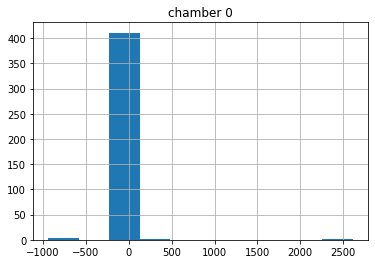

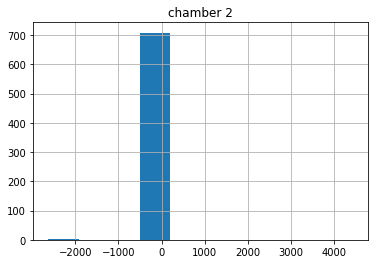

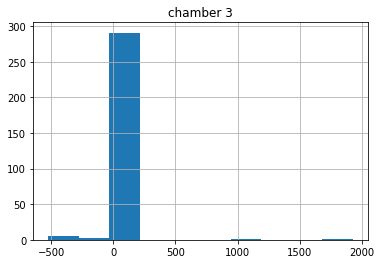

In [60]:
for i in [0, 2, 3] :
    plt.figure();
    s1[i].hist();
    plt.title(f'chamber {i}')

Chamber 2 nell'istogramma precedente: praticamente come al caruso. Camere 0 e 3: sballate dal non aver tolto quelli che non rispettano la vicinanza orizzontale!          
In ogni caso questo modo di procedere è effettivamente migliore del precedente, visto che sommando i residui relativi solo ad una camera (quindi non tutti) non ottengo necessariamente 0, anzi in generale tutt'altro!

P.S. ovviamente la camera 1 è stata esclusa da questo discorso

In [61]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s1[i].std()) # e infatti le camere sballate hanno sigma enormi

std ch. 0 -> 151.7627687934772
std ch. 2 -> 219.11428898713032
std ch. 3 -> 145.08415865941632


In [62]:
# e se provassi ad eliminare la spazzatura ricorrendo ai residui stessi?
df2d_3 = df2d_2[df2d_2.residui.abs() < 15] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_3

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
1426,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673,2.164219
1427,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827,-1.656821
1428,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-0.317189
1429,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767,-0.210408


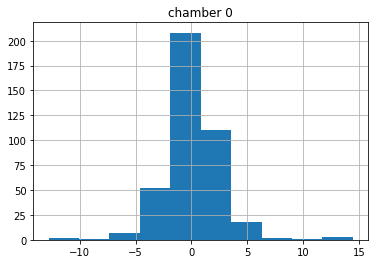

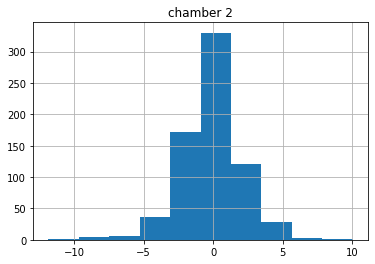

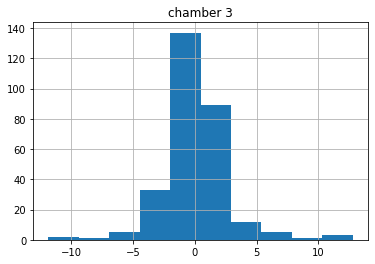

In [63]:
s2 = df2d_3.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s2[i].hist();
    plt.title(f'chamber {i}');

In [64]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s2[i].std())

std ch. 0 -> 2.6335784517685075
std ch. 2 -> 2.2286533945646605
std ch. 3 -> 2.6640432274544636


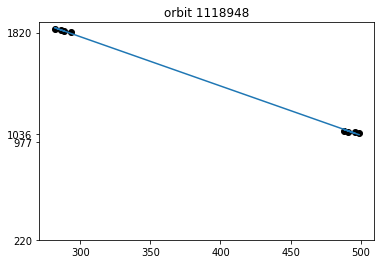

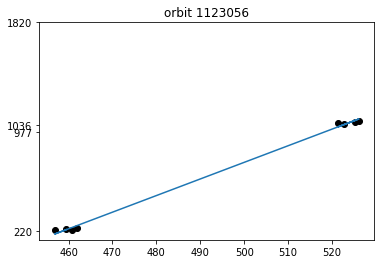

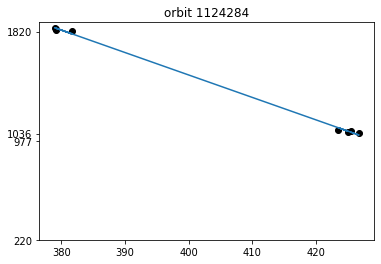

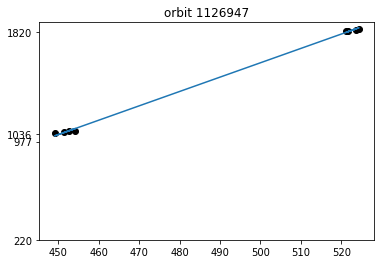

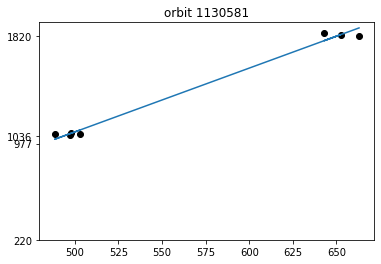

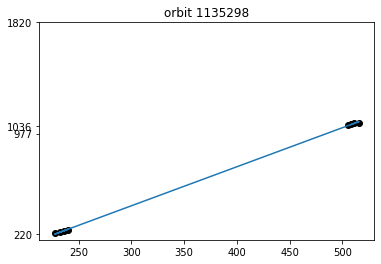

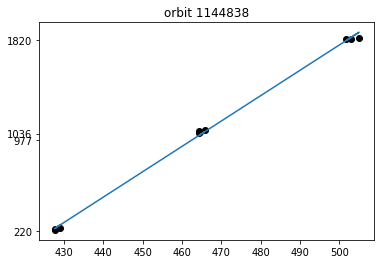

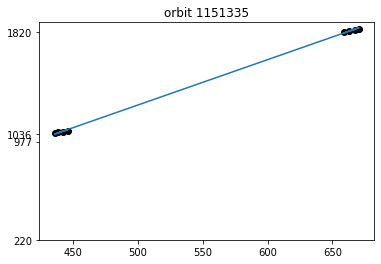

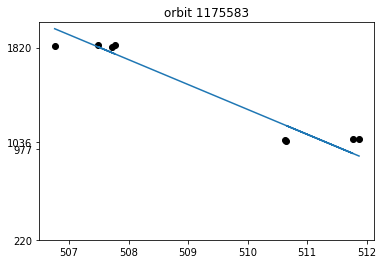

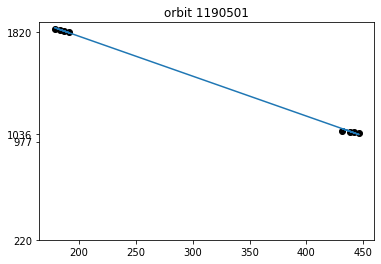

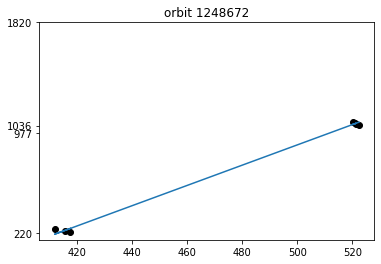

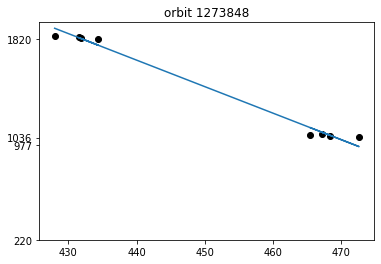

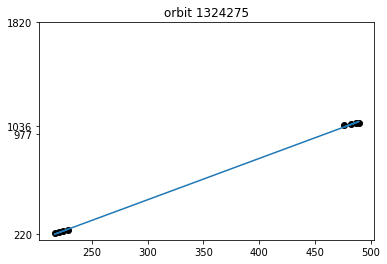

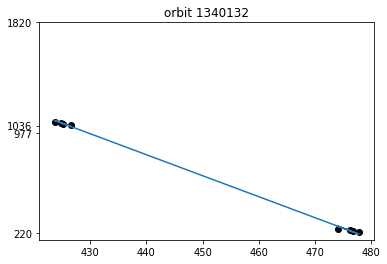

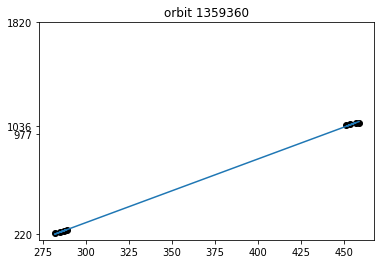

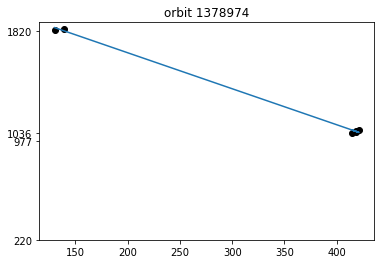

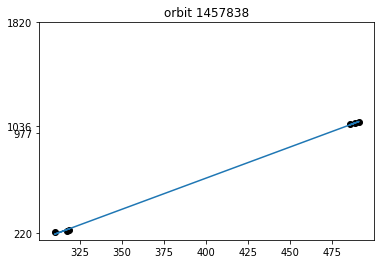

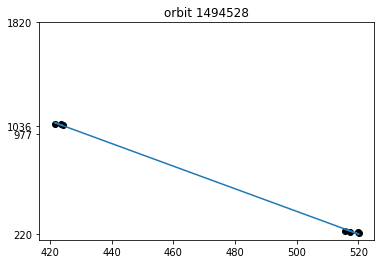

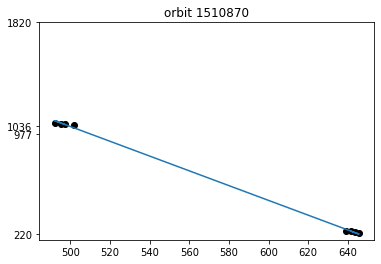

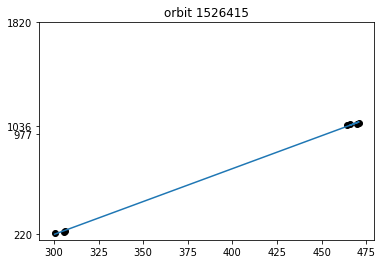

In [65]:
for i in range(20) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]])

l'orbita 1273848 comunque si comporta male, mm... Un sigma più stringente?

In [66]:
df2d_4 = df2d_2[df2d_2.residui.abs() < 10] # valore indicativo, un po' inventato in realtà. Sarebbe meglio stimarlo sulla base dell'errore accettabile!
df2d_4

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
1,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
2,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
3,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
4,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
1426,5762142,0,2,25,272.633333,539.667673,510.332327,232.8,539.667673,2.164219
1427,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827,-1.656821
1428,5762142,2,1,22,23.000000,463.237400,460.762600,1042.1,460.762600,-0.317189
1429,5762142,2,3,22,43.833333,464.358233,459.641767,1055.1,459.641767,-0.210408


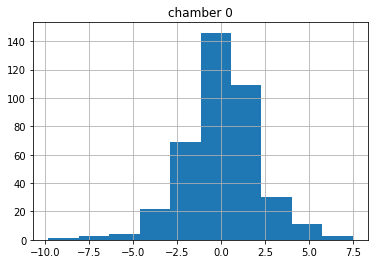

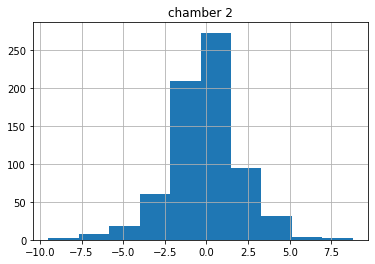

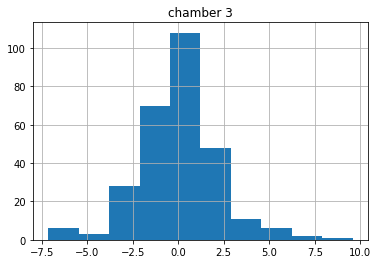

In [67]:
s3 = df2d_4.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in [0, 2, 3] : # le uniche camere che ho a disposizione se manca la 1
    plt.figure();
    s3[i].hist();
    plt.title(f'chamber {i}');

In [68]:
for i in [0, 2, 3] : # non c'è 1
    print('std ch.', i, '->', s3[i].std())

std ch. 0 -> 2.1442616338441187
std ch. 2 -> 2.1140389862272286
std ch. 3 -> 2.1584714016088133


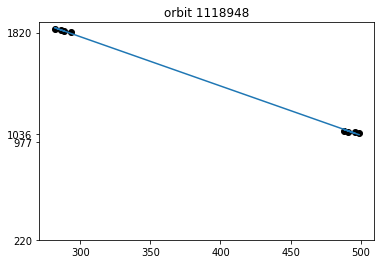

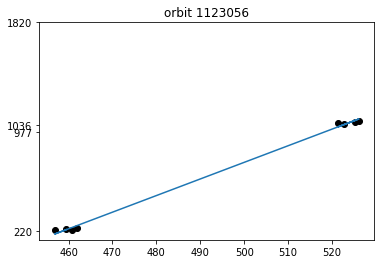

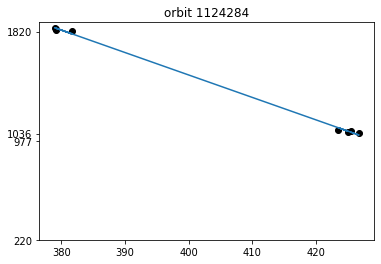

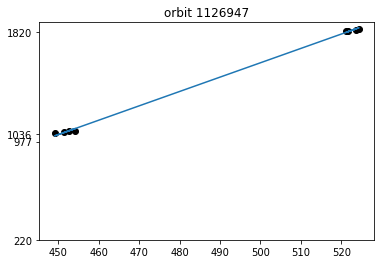

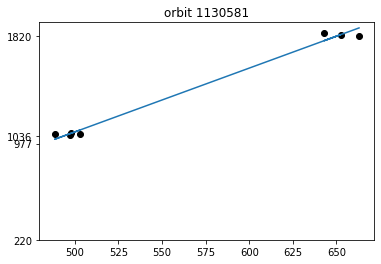

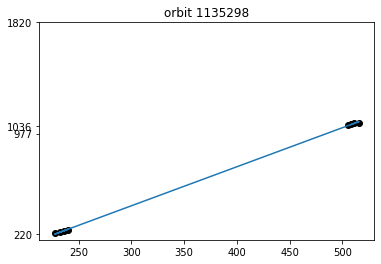

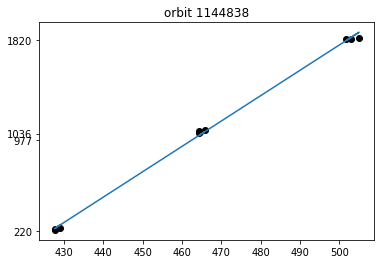

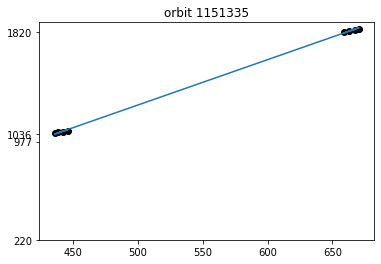

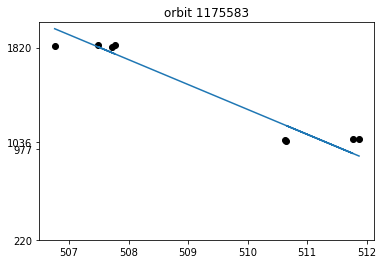

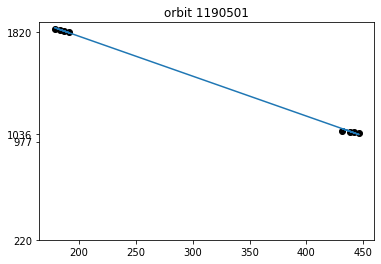

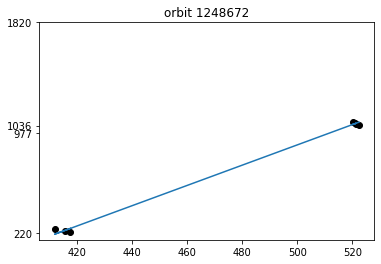

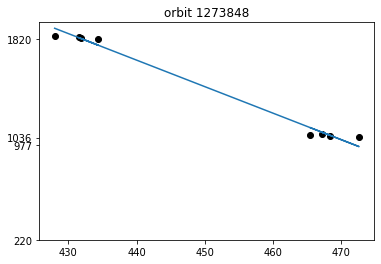

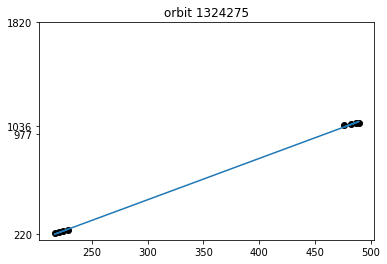

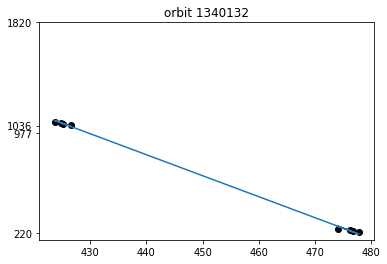

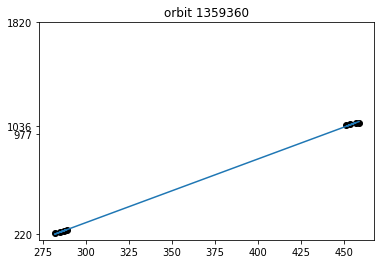

In [69]:
for i in range(15) :
    plot_global_fit(df2d_3[df2d_3.orbit == df2d_3.orbit.unique()[i]]) # ancora passa quella disgraziata, grrr

# Fit 3d: non scarto 1 e anzi chiedo che ci sia almeno un'altra camera

In [70]:
df3d = df5.copy()

def filtro3d(gruppo) :
    if 1 in gruppo.chamber.unique() and len(gruppo.chamber.unique()) > 2 : # mi serve ad esempio 0-1 per yz e 0-2 per xz, quindi camera 1 + almeno altre 2. Questo significa minimo 3 in totale!
        return gruppo 
    else :
        return None

df3d = df3d.groupby('orbit').apply(filtro3d).reset_index(drop = True).dropna()
df3d # ovviamente c'è molta più roba

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
...,...,...,...,...,...,...,...,...,...
1611,5741793,1,1,28,223.266667,600.011747,575.988253,983.8,575.988253
1612,5741793,2,4,25,21.333333,526.147733,523.852267,1061.6,523.852267
1613,5741793,2,1,24,139.866667,511.524827,496.475173,1042.1,511.524827
1614,5741793,2,2,25,191.733333,535.315253,514.684747,1048.6,514.684747


In [71]:
#cella copiata da sopra; la rimetto qui per avere un blueprint per quella 3d e per poter fare eventuali modifiche alla stessa senza dover risalire 100 volte
def plot_global_fit(event) :
    vxb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vxb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vxb, vz, c = 'black')
    ax.plot(vxb, m*vxb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

    ax.axis('equal')

In [72]:
# temo si possa graficare solo la retta! Infatti per le hits abbiamo solo x e z o y e z, mai tutti e tre insieme

def plot_3d(event) :
    vx = event[event.chamber != 1].xb.to_numpy()
    vzx = event[event.chamber != 1].z.to_numpy()

    vy = event[event.chamber == 1].xb.to_numpy()
    vzy = event[event.chamber == 1].z.to_numpy()

    # formule per mettere insieme le due pendenze sui due piani... (magari di intercept fai la media? O magari stampa solamente di quanto differiscono i due)
    m1, q1 = fit(vzx, vx)
    m2, q2 = fit(vzy, vy)

    #return m1, m2, -q1/m1, -q2/m2
    t = np.linspace(170, 2000) # z è sempre più o meno fra 200 e 1840, ma allungo un po'
    #t = np.linspace(-2000, 100)
    X = q1 + m1*t
    Y = q2 + m2*t
    Z = t 
    fig = px.line_3d(x = X, y = Y, z = Z) # creo la figura di go con una sola chiamata semplice mediante px, e poi aggiorno l'oggetto fig

    # BLOCCO SE VOGLIO SOLO LA FETTA DI SOTTO DI OGNI CAMERA
    # X_s, Y_s = np.meshgrid(np.linspace(0, 21+16*42, 10), np.linspace(0, 16*42, 10)) # X va da 0 a 21 + 42*16 (16 celle nei layer traslati), Y riguarda solo la camera 1 (quindi penso vada bene 16*42)
    # for i in range(4) : # le 4 camere
    #     fig.add_surface(x = X_s, y = Y_s, z = z_offset[i]*np.ones(X_s.shape))
    # alla fine penso che comunque vada bene anche una cosa meno raffinata come assumere semplicemente detector quadrati lunghi 42*16.5 mm per lato, con 13*4 mm di altezza

    l = 42*16.5
    X_s = [0, l, l, 0]*2
    Y_s = [0, 0, l, l]*2
    Z_s = np.array([0]*4 + [13*4]*4)
    for i in range(4) : # le 4 camere
        fig.add_mesh3d( 
            x = X_s, y = Y_s, z = Z_s + z_offset[i],
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2], # https://stackoverflow.com/questions/60371624/drawing-a-3d-box-in-a-3d-scatterplot-using-plotly
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            opacity = 0.25,
            color = '#DC143C',
            flatshading = True # fondamentale
        )

    return fig

In [73]:
p = plot_3d(df3d.loc[df3d.orbit == df3d.orbit.unique()[0]])
p

In [74]:
#p.add_mesh3d?

In [75]:
#p.add_surface?

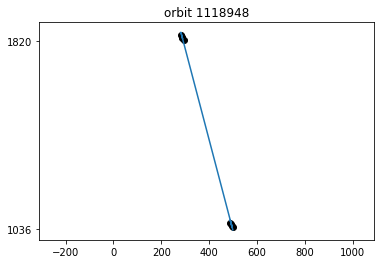

In [76]:
plot_global_fit(df3d.loc[(df3d.orbit == df3d.orbit.unique()[0]) & (df3d.chamber != 1)])

In [77]:
def plot_fit_ch1(event) :
    vyb = event.xb.to_numpy()
    vz = event.z.to_numpy()

    slope, intercept = fit(vz, vyb) # faccio il fit solo con le x best!
    q = -intercept/slope 
    m = 1/slope # cfr notebook di Zanetti per vedere come "raddrizzare" GEOMETRICAMENTE la retta (riflessione ortogonale)

    fig, ax = plt.subplots()
    ax.scatter(vyb, vz, c = 'black')
    ax.plot(vyb, m*vyb + q)
    ax.set_title(f'orbit {event.orbit.iloc[0]}')
    #ax.set_yticks(z_offset) # le altezze delle camere (le due centrali sono appiccicate)

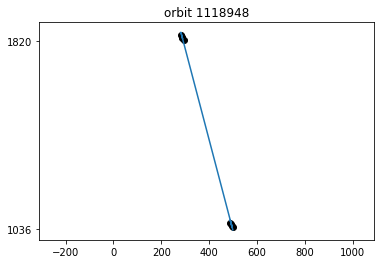

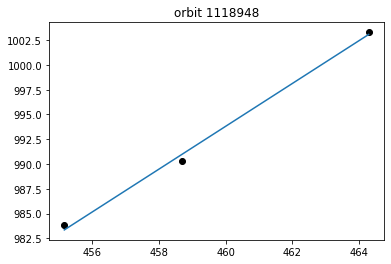

In [78]:
tmp = df3d.loc[df3d.orbit == df3d.orbit.unique()[0]]
tmp1 = tmp[tmp.chamber == 1]
tmp2 = tmp[tmp.chamber != 1]

plot_global_fit(tmp2)
plot_fit_ch1(tmp1)

In [79]:
tmp1

,orbit,chamber,layer,center,dt,xr,xl,z,xb
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773


In [80]:
tmp2

,orbit,chamber,layer,center,dt,xr,xl,z,xb
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193


***
## Distanza orizzontale vs 7 eventi/orbita max
***

In [81]:
df6 = df5.copy()
df6 = df6.groupby('orbit').apply(residui).reset_index(drop = True) # residui rispetto al fit globale
df6

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
0,1118948,1,1,22,127.233333,468.845153,455.154847,983.8,455.154847,-32.755015
1,1118948,1,2,21,328.700000,458.684060,423.315940,990.3,458.684060,-27.708210
2,1118948,1,4,23,347.866667,501.715227,464.284773,1003.3,464.284773,-19.072312
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,24.529797
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,18.247186
...,...,...,...,...,...,...,...,...,...,...
3208,5762142,2,4,21,349.033333,459.777993,422.222007,1061.6,459.777993,0.539625
3209,5773565,1,1,28,55.366667,590.978727,585.021273,983.8,590.978727,-0.216469
3210,5773565,1,3,28,199.733333,598.745653,577.254347,996.8,598.745653,1.479281
3211,5773565,1,4,29,177.433333,618.545913,599.454087,1003.3,599.454087,-0.847875


std ch. 0 -> 131.2982412945654
std ch. 1 -> 109.91269019970134
std ch. 2 -> 177.79752862924911
std ch. 3 -> 132.17487793265505


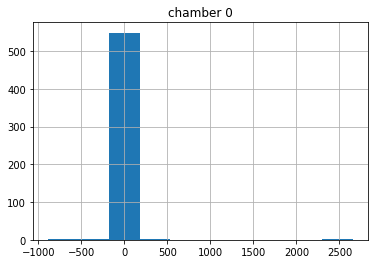

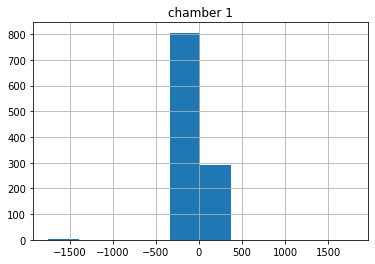

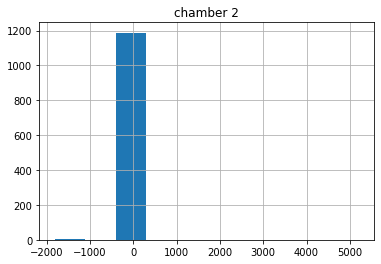

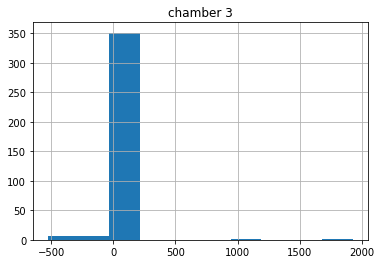

In [82]:
s4 = df6.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in range(4) : # ho tutte le camere a disposizione per ora
    plt.figure();
    s4[i].hist();
    plt.title(f'chamber {i}');

for i in range(4) : # non c'è 1
    print('std ch.', i, '->', s4[i].std())

df6a = df6 + filtro orizzontale, df6b = df6 + filtro < 8 hits per evento

In [83]:
df6a = df6.copy()
df6b = df6.copy()

In [90]:
def vicinanza(gruppo) :
    #g = gruppo.sort_values('z') # layer c'è ancora
    g = gruppo.sort_values('layer')
    if (g['layer'].diff().abs() > 1).any() :
        return False # non voglio salti verticali per non dovermi preoccupare di sistemare la formula seguente
    return (g['center'].diff().abs() < 2).any() # se le differenze orizzontali da un livello all'altro sono al più 1 ok, se superano 1 butto

In [105]:
# qui sto controllando una condizione locale, quindi devo necessariamente raggruppare per orbit e per chamber
df6a = df6a.groupby(['orbit', 'chamber']).filter(vicinanza)
df6a = df6a.groupby('orbit').apply(residui) # nota che siccome potenzialmente rimuovo alcune camere dentro orbite che però lascio il fit globale va aggiornato, quindi devo ricalcolare i residui
print(len(df6a)/len(df6)*100)
df6a

49.517584811702456


,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
...,...,...,...,...,...,...,...,...,...,...
3205,5762142,0,3,26,200.133333,556.767173,535.232827,239.3,535.232827,-1.652811
3209,5773565,1,1,28,55.366667,590.978727,585.021273,983.8,590.978727,-0.216469
3210,5773565,1,3,28,199.733333,598.745653,577.254347,996.8,598.745653,1.479281
3211,5773565,1,4,29,177.433333,618.545913,599.454087,1003.3,599.454087,-0.847875


In [106]:
df6a.iloc[:8] # sembra ok

,orbit,chamber,layer,center,dt,xr,xl,z,xb,residui
3,1118948,2,1,24,96.133333,509.171973,498.828027,1042.1,498.828027,2.814740
4,1118948,2,4,23,92.800000,487.992640,478.007360,1061.6,487.992640,-2.896574
5,1118948,2,3,24,243.833333,517.118233,490.881767,1055.1,490.881767,-1.715472
6,1118948,2,2,23,240.500000,495.938900,470.061100,1048.6,495.938900,1.633637
7,1118948,3,1,14,17.000000,294.914600,293.085400,1826.3,293.085400,3.138674
8,1118948,3,4,13,163.033333,281.771193,264.228807,1845.8,281.771193,-3.051460
9,1118948,3,3,14,142.200000,301.650360,286.349640,1839.3,286.349640,-0.181037
10,1118948,3,2,13,288.033333,288.496193,257.503807,1832.8,288.496193,0.257492


In [117]:
# nota che in df6 ho già risolto l'ambiguità e calcolato i residui, quindi mi interessa solo la prospettiva globale; pertanto non mi serve raggruppare per camera, solo per orbita
sb = df6b.groupby('orbit').size()
#sbb = sb[sb < 8].index
sb2 = df6.groupby('orbit').nunique()['chamber']*7
sbb = sb[sb < sb2].index
df6b = df6b[df6b.orbit.isin(sbb)]
print(len(df6b)/len(df6)*100)
df6b
# non ho bisogno di ricalcolare i residui perché o tengo o butto tutta l'orbita, che è la sola cosa a decidere le sorti del fit globale

ValueError: Can only compare identically-labeled Series objects

In [120]:
len(df6b.groupby('orbit').size())

150

In [127]:
sb.reset_index().sort_values('orbit').set_index('orbit')

,0
orbit,
1150842,4
1209695,4
1247112,4
1252229,3
1322269,4
...,...
5738703,7
5744493,4
5759592,3


In [119]:
df6.groupby('orbit').nunique()['chamber']

orbit
1118948    3
1123056    3
1124284    3
1126947    3
1130581    3
          ..
5741793    3
5744493    1
5759592    1
5762142    2
5773565    1
Name: chamber, Length: 392, dtype: int64

In [115]:
# test per qui sopra
df6.groupby('orbit').nunique()['chamber']

orbit
1118948    3
1123056    3
1124284    3
1126947    3
1130581    3
          ..
5741793    3
5744493    1
5759592    1
5762142    2
5773565    1
Name: chamber, Length: 392, dtype: int64

std ch. 0 -> 232.29668988304633
std ch. 1 -> 157.42551168984835
std ch. 2 -> 227.87326321027513
std ch. 3 -> 94.81723205546422


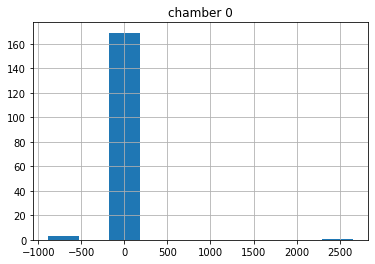

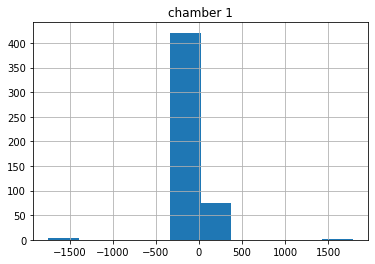

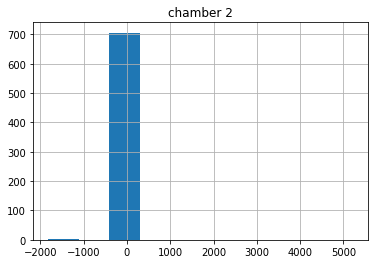

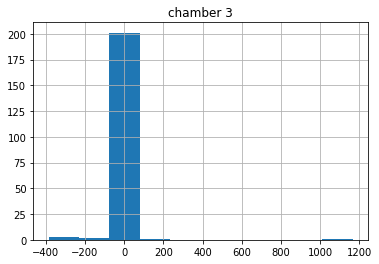

In [107]:
s5a = df6a.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in range(4) : # ho tutte le camere a disposizione per ora
    plt.figure();
    s5a[i].hist();
    plt.title(f'chamber {i}');

for i in range(4) : # non c'è 1
    print('std ch.', i, '->', s5a[i].std())

In [102]:
# for reference
for i in range(4) : # non c'è 1
    print('std ch.', i, '->', s4[i].std())

std ch. 0 -> 131.2982412945654
std ch. 1 -> 109.91269019970134
std ch. 2 -> 177.79752862924911
std ch. 3 -> 132.17487793265505


std ch. 0 -> 38.16671206081707
std ch. 1 -> 7.395724444421115
std ch. 2 -> 4.034702767686986
std ch. 3 -> 2.3825976299743776


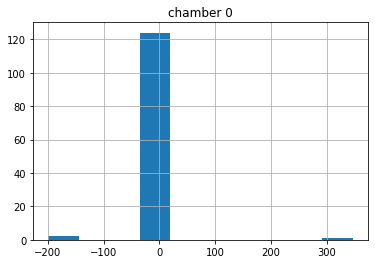

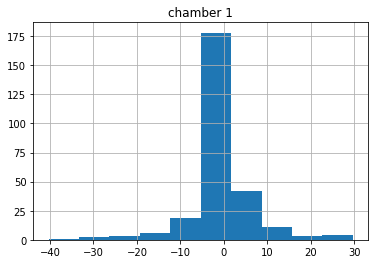

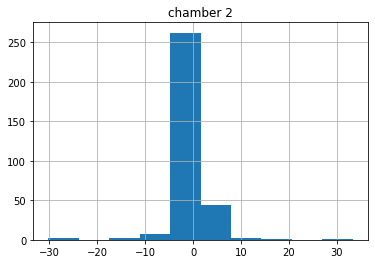

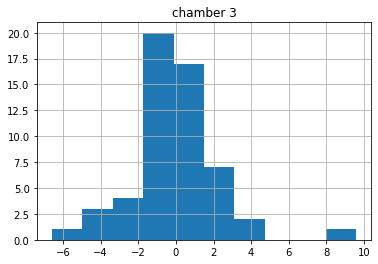

In [95]:
s5b = df6b.groupby('chamber').apply(lambda gruppo: gruppo.residui)

for i in range(4) : # ho tutte le camere a disposizione per ora
    plt.figure();
    s5b[i].hist();
    plt.title(f'chamber {i}');

for i in range(4) : # non c'è 1
    print('std ch.', i, '->', s5b[i].std())